## Extract keywords 

# Transformer analysis of open problems against pubmed articles

# Extract key words

**For each open problem we extract the keywords, especially biomedical related ones**

In [1]:
#imports 
import re
import json
import csv

import pandas as pd

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import pipeline 

from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

from keyphrase_vectorizers import KeyphraseCountVectorizer

import scispacy

import torch

import requests

import time

from Bio import Entrez

from tqdm import tqdm

import ast



/home/angelotalay/miniconda3/envs/opl/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/angelotalay/miniconda3/envs/opl/lib/python3.8/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### Extract open problem titles

And get the descriptions just in case.

In [4]:
open_problems_df = pd.read_csv("initial_top_100.csv")
open_problems_df.columns

titles = open_problems_df['titles']
titles.head(10)

0    How do we distinguish ageing from disease (if ...
1    How to reverse or restore cell function lost d...
2                   Can we live longer than 120 years?
3    Which cellular changes that contribute to agei...
4    How does the body compensate and adapt to any ...
5    How much does oxidation of proteins and lipids...
6    How much does oxidative DNA damage contribute ...
7    How much does the immune response to mutated c...
8    Are there are specific tissues or cell types t...
9    How much does telomere shortening contribute t...
Name: titles, dtype: object

### Extract the key words from titles 

In [5]:
sentence_model = SentenceTransformer("pritamdeka/S-PubMedBert-MS-MARCO")
kw_model = KeyBERT(model=sentence_model)

In [6]:
ageing_stop_words = ["ageing", "longevity", "aging"]

In [7]:
def extract_keywords(text, ngram_range): 
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=ngram_range, stop_words='english', use_mmr=True, diversity=0.5)
    # Sort the keywords by score in descending order
    keywords = sorted(keywords, key=lambda x: x[1], reverse=True)
    # Filter keywords with score >= 0.85
    return [k for k in keywords if k[0] not in ageing_stop_words]

In [8]:
def extract_keywords_vectorizer(text, pipeline): 
    keywords = kw_model.extract_keywords(text, vectorizer=KeyphraseCountVectorizer(spacy_pipeline=pipeline))
    keywords = sorted(keywords, key=lambda x: x[1], reverse=True)
    # Filter keywords with score >= 0.85
    return [k for k in keywords if k[0] not in ageing_stop_words]

In [10]:
ngram_1 = open_problems_df.copy()
ngram_1["title_keywords"] = ngram_1["titles"].apply(lambda text: extract_keywords(text, ngram_range=(1, 1)))

In [11]:
ngram_2 = open_problems_df.copy()
ngram_2["title_keywords"] = ngram_2["titles"].apply(lambda text: extract_keywords(text, ngram_range=(1, 2)))

In [12]:
ngram_3 = open_problems_df.copy()
ngram_3["title_keywords"] = ngram_3["titles"].apply(lambda text: extract_keywords(text, ngram_range=(1, 3)))

In [13]:
vectoriser = open_problems_df.copy()
vectoriser["title_keywords"] = vectoriser["titles"].apply(lambda text: extract_keywords_vectorizer(text, "en_core_sci_lg"))

In [14]:
vectoriser_non_scispacy = open_problems_df.copy()
vectoriser_non_scispacy["title_keywords"] = vectoriser_non_scispacy["titles"].apply(lambda text: extract_keywords_vectorizer(text, "en_core_web_lg"))

In [15]:
ngram_3.to_csv("title_keywords_ngram3.csv")
ngram_2.to_csv("title_keywords_ngram2.csv")
ngram_1.to_csv("title_keywords_ngram1.csv")
vectoriser.to_csv("title_keywords_ngram_vec.csv")

In [16]:
keywords = ngram_1
keywords["title_keywords_2"] = ngram_2.loc[:,"title_keywords"]
keywords["title_keywords_3"] = ngram_3.loc[:, "title_keywords"]
keywords["title_keywords_v"] = vectoriser.loc[:, "title_keywords"]
keywords["title_keywords_v2"] = vectoriser_non_scispacy.loc[:,"title_keywords"]

In [17]:
keywords.to_csv("title_keywords.csv")

## PubMed article search using MeSH terms and keywords

For now, use the first 10 open problems. For testing purposes.

Use the keyword for each article and then get the xml output of each. 

In [18]:
Entrez.email = "angelogabrieltalay@gmail.com"

In [19]:
title_keywords_df = pd.read_csv("title_keywords.csv")
top_10 = title_keywords_df.head(10)
keywords_df = title_keywords_df.copy()
keywords_df.head(20)

,Unnamed: 0.1,Unnamed: 0,titles,counts,ids,queries,title_keywords,title_keywords_2,title_keywords_3,title_keywords_v,title_keywords_v2
0,0,12,How do we distinguish ageing from disease (if ...,80491,"['39085958', '39085294', '39085217', '39085088...",(disease) AND (Ageing[MeSH Terms]),"[('disease', 0.9047), ('distinguish', 0.8868),...","[('distinguish ageing', 0.95), ('ageing diseas...","[('distinguish ageing disease', 0.9687), ('age...","[('disease', 0.9047)]","[('disease', 0.9047)]"
1,1,80,How to reverse or restore cell function lost d...,64043,"['39085294', '39085217', '39085056', '39082763...",(cell function) AND (Ageing[MeSH Terms]),"[('restore', 0.882), ('reverse', 0.88), ('cell...","[('restore cell', 0.911), ('cell function', 0....","[('restore cell function', 0.9294), ('cell fun...","[('cell function', 0.8881)]","[('cell function', 0.8881)]"
2,2,82,Can we live longer than 120 years?,56458,"['39085152', '39082776', '39082773', '39082763...",(years) AND (Ageing[MeSH Terms]),"[('longer', 0.9047), ('years', 0.8793), ('120'...","[('120 years', 0.9307), ('longer 120', 0.9283)...","[('longer 120 years', 0.9551), ('live longer 1...","[('years', 0.8793)]","[('years', 0.8793)]"
3,3,2,Which cellular changes that contribute to agei...,28052,"['39085654', '39082763', '39080289', '39078383...",(cellular changes) AND (cell) AND (Ageing[MeSH...,"[('cellular', 0.8901), ('originate', 0.8806), ...","[('ageing originate', 0.9413), ('contribute ag...","[('ageing originate cell', 0.9619), ('contribu...","[('cellular changes', 0.9084), ('cell', 0.892)]","[('cellular changes', 0.9084), ('cell', 0.892)]"
4,4,67,How does the body compensate and adapt to any ...,21500,"['39082773', '39082711', '39073820', '39073814...",(body) AND (age) AND (Ageing[MeSH Terms]),"[('compensate', 0.8997), ('adapt', 0.8969), ('...","[('body compensate', 0.9217), ('adapt age', 0....","[('compensate adapt age', 0.941), ('does body ...","[('body', 0.8809)]","[('body', 0.8809), ('age', 0.8768), ('change',..."
5,5,112,How much does oxidation of proteins and lipids...,14021,"['39085294', '39076782', '39064801', '39063184...",(oxidation) AND (proteins) AND (Ageing[MeSH Te...,"[('oxidation', 0.9007), ('proteins', 0.886), (...","[('oxidation proteins', 0.9275), ('contribute ...","[('oxidation proteins lipids', 0.9383), ('lipi...","[('oxidation', 0.9007), ('proteins', 0.886), (...","[('oxidation', 0.9007), ('proteins', 0.886), (..."
6,6,125,How much does oxidative DNA damage contribute ...,13438,"['39085294', '39082360', '39078383', '39076782...",(oxidative dna damage) AND (Ageing[MeSH Terms]),"[('oxidative', 0.9073), ('damage', 0.8956), ('...","[('oxidative dna', 0.9336), ('damage', 0.8956)...","[('oxidative dna damage', 0.947), ('damage con...","[('oxidative dna damage', 0.947)]","[('oxidative dna damage', 0.947)]"
7,7,149,How much does the immune response to mutated c...,7660,"['39078383', '39064833', '39064733', '39059365...",(immune response) AND (cells) AND (Ageing[MeSH...,"[('immune', 0.8803), ('mutated', 0.8741), ('ce...","[('mutated cells', 0.8995), ('contribute agein...","[('immune response mutated', 0.9272), ('cells ...","[('immune response', 0.8954), ('cells', 0.8551)]","[('immune response', 0.8954), ('cells', 0.8551)]"
8,8,3,Are there are specific tissues or cell types t...,7522,"['39034400', '39026669', '39012929', '39009581...",(specific tissues) AND (cell types) AND (Agein...,"[('tissues', 0.8689), ('contribution', 0.8651)...","[('contribution ageing', 0.908), ('specific ti...","[('bigger contribution ageing', 0.9187), ('cel...","[('specific tissues', 0.8929), ('cell types', ...","[('specific tissues', 0.8929), ('cell types', ..."
9,9,159,How much does telomere shortening contribute t...,6204,"['39085056', '39062937', '39055058', '39037376...",(shortening) AND (Ageing[MeSH Terms]),"[('telomere', 0.9057), ('shortening', 0.8895),...","[('telomere shortening', 0.9434), ('shortening...","[('telomere shortening contribute', 0.9637), (...","[('telomere shortening', 0

Use the top two of the keywords extracted using the scispacy pipeline. If there is only one then use one. 

In [20]:

def perform_search(query, mindate="1964", maxdate="2024"):
    """Performs a PubMed search with the given query and date range."""
    handle = Entrez.esearch(db="pubmed", term=query, retmax=9999, mindate=mindate, maxdate=maxdate)
    record = Entrez.read(handle)
    handle.close()
    return record

def construct_query(keywords, use_all=True):
    """Constructs a query string from the given keywords and MeSH term."""
    ageing_query = "(Ageing[MeSH Terms])"
    if use_all and len(keywords) > 1:
        extracted_keywords = [f"({keyword[0]})" for keyword in keywords[:2] if isinstance(keyword, tuple) and len(keyword) > 0]
        keyword_query = " AND ".join(extracted_keywords)
    else:
        if isinstance(keywords[0], tuple) and len(keywords[0]) > 0:
            keyword_query = f"({keywords[0][0]})"
        else:
            keyword_query = "(Ageing)"  # Fallback in case the keyword structure is incorrect

    return f"{keyword_query} AND {ageing_query}"

def search_pubmed(title, keywords, backup_keywords):
    """Searches PubMed with the given title and keywords, and uses backup keywords if necessary."""
    record_dict = {}

    # Use backup keywords if the initial keywords are empty
    if not keywords:
        keywords = backup_keywords

    keywords = ast.literal_eval(keywords)

    # Construct and perform the initial query with two keywords
    query = construct_query(keywords, use_all=True)
    record = perform_search(query)

    # Check if results are found, if not, retry with only the first keyword
    if record["Count"] == "0":
        query = construct_query(keywords, use_all=False)
        record = perform_search(query)

    # Store the results in a dictionary
    record_dict["counts"] = record["Count"]
    record_dict["ids"] = record["IdList"]
    record_dict["query"] = query

    return record_dict

In [22]:
# Perform searches and store article IDs
article_ids = {"titles": [], "counts": [], "ids":[], "queries": []}
for idx, row in tqdm(keywords_df.iterrows(), total=keywords_df.shape[0]):
    try: 
        sci_spacy_keywords = row['title_keywords_v2']
        backup_keywords = row["title_keywords_2"]
        title = row['titles']
        record_dict = search_pubmed(title,sci_spacy_keywords, backup_keywords)
        article_ids["titles"].append(title)
        article_ids["counts"].append(record_dict["counts"])
        article_ids["ids"].append(record_dict["ids"])
        article_ids["queries"].append(record_dict["query"])
    except IndexError: 
        sci_spacy_keywords = row["title_keywords_v2"]
        


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


In [23]:
# Save the article ids into a json file 
import json 
with open("article_ids.json", mode="w") as file: 
    json.dump(article_ids, file, indent=4 )

### Analysis of pmid counts 

We want to see the distribution of articles with all the ids. 

In [62]:
article_ids_df = pd.read_json('article_ids.json', orient='columns')
article_ids_df.head(10)

,titles,counts,ids,queries
0,Which changes in model organisms associated wi...,3389,"[39069555, 39064733, 39056774, 39051470, 39012...",(model organisms) AND (humans) AND (Ageing[MeS...
1,Can we come up with better markers that repres...,88,"[38880169, 38788541, 38685363, 37993053, 37966...",(mice) AND (better markers) AND (Ageing[MeSH T...
2,Which cellular changes that contribute to agei...,28052,"[39085654, 39082763, 39080289, 39078383, 39064...",(cellular changes) AND (cell) AND (Ageing[MeSH...
3,Are there are specific tissues or cell types t...,7522,"[39034400, 39026669, 39012929, 39009581, 39009...",(specific tissues) AND (cell types) AND (Agein...
4,Can we apply stem cell therapy based on our ow...,217,"[38858695, 38791313, 38638133, 38520027, 38433...",(stem cell therapy) AND (young stem cells) AND...
5,What ageing-related processes cannot be target...,223,"[39000517, 38987161, 38725847, 38649488, 38483...",(lifestyle interventions) AND (pharmacological...
6,Will therapies based on young cells work in an...,2985,"[38965562, 38939932, 38928437, 38904042, 38892...",(young cells) AND (therapies) AND (Ageing[MeSH...
7,Which cellular and molecular changes primary c...,134,"[39059424, 38950629, 38851726, 38789057, 38781...",(molecular changes) AND (primary contribute) A...
8,What do the current (epigenetic) clocks measur...,191,"[39073811, 39069614, 38944768, 38928497, 38886...",(clocks) AND (molecular processes) AND (Ageing...
9,Is there a limited number of common triggers f...,212,"[39064687, 38718507, 38521064, 38213100, 38173...",(common triggers) AND (diseases) AND (Ageing[M...


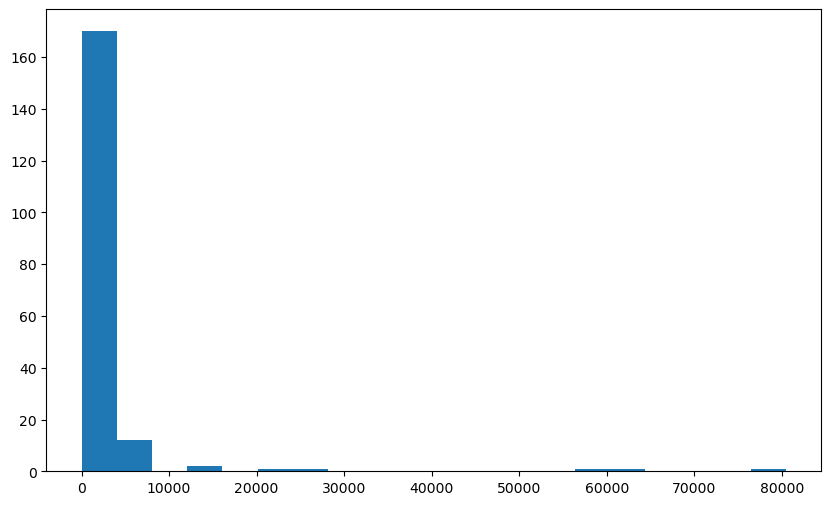

In [63]:
def plot_counts_histogram(dataframe):
    plt.figure(figsize=(10,6))
    plt.hist(dataframe['counts'], bins=20)

plot_counts_histogram(article_ids_df)
    
    

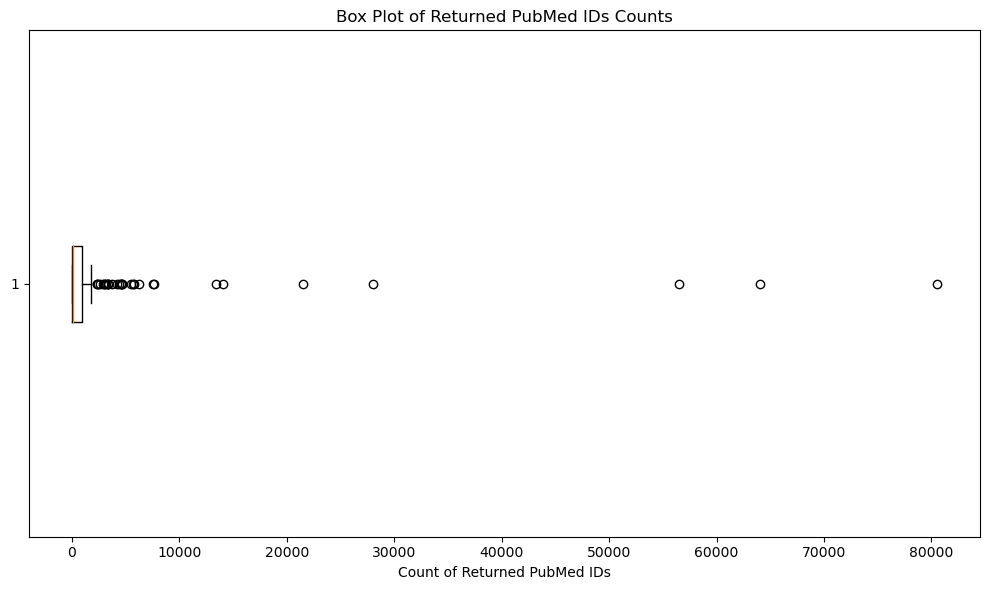

In [64]:
def plot_boxplot(dataframe):
    plt.figure(figsize=(10, 6))
    plt.boxplot(dataframe['counts'], vert=False)
    plt.xlabel('Count of Returned PubMed IDs')
    plt.title('Box Plot of Returned PubMed IDs Counts')
    plt.tight_layout()
    plt.show()

# Plotting
plot_boxplot(article_ids_df)


We need to check the outliers. First we will look at the queries with over 20,000 returned PMIDs.

In [65]:
article_ids_df.describe()

,counts
count,189.000000
mean,2236.407407
std,8924.112135
min,0.000000
25%,14.000000
50%,105.000000
75%,934.000000
max,80491.000000


In [67]:
top_100 = article_ids_df.sort_values(["counts"], ascending=False).head(100)
top_100.to_csv("initial_top_100.csv")